# 1. Notebook Introduction
This notebook provides a complete pipeline to train and evaluate a depth prediction model by applying knowledge distillation.
The student's architecture is a Unet with a ResNet18 backbone and the teacher will be one of the biggest Depth Anything V3 model (DA3NESTED-GIANT-LARGE).
The training stage is tracked with MLFlow and the best set of hyperparameters are found by an Optuna study.

# 2. Imports and Setup

In [1]:
import os
import gc
import joblib
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import segmentation_models_pytorch as smp
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from collections import defaultdict

import mlflow
from mlflow.tracking import MlflowClient
import optuna
import optuna.visualization as viz
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.loggers import MLFlowLogger

# Set random seed for reproducibility
pl.seed_everything(42, workers=True)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Seed set to 42


Using device: cuda


# 3. Classes and Definitions

## 3.1 Dataset Class
Custom dataset class. It implements manual HorizontalFlip and ColorJitter transformations, so they can be applied not only to the input images but also to the Teacher's depth maps (only HorizontalFlip).

In [2]:
class DepthDistillationDataset(Dataset):
    def __init__(self, img_dir, depth_dir, is_train=False, prob=None):
        """
        Args:
            img_dir: Directory with input images
            depth_dir: Directory with teacher depth maps (.npy files)
            is_train: Whether this is training dataset (for augmentation)
            prob: Dictionary with augmentation probabilities 
                  {'horizontal_flip': float, 'color_jitter': float}
        """
        self.img_dir = img_dir
        self.depth_dir = depth_dir
        self.is_train = is_train
        self.prob = prob if prob is not None else {'horizontal_flip': 0.5, 'color_jitter': 0.5}
        
        # Get list of images
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load teacher predictions
        depth_path = os.path.join(self.depth_dir, img_name.replace('.png', '.npy'))
        teacher_depth = np.load(depth_path)
        
        # Apply synchronized augmentations if training
        if self.is_train:
            # Random horizontal flip
            if torch.rand(1).item() < self.prob['horizontal_flip']:
                image = TF.hflip(image)
                teacher_depth = np.fliplr(teacher_depth).copy()
            
            # Color jitter (only on image)
            if torch.rand(1).item() < self.prob['color_jitter']:
                color_jitter = T.ColorJitter(brightness=0.25, contrast=0.25)
                image = color_jitter(image)
        
        # Convert to tensors
        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        teacher_depth = torch.from_numpy(teacher_depth).float()
        
        return image, teacher_depth

## 3.2 Data Module Class

In [3]:
class DataModule(pl.LightningDataModule):
    def __init__(self, 
                 train_img_dir, train_depth_dir,
                 val_img_dir, val_depth_dir,
                 test_img_dir, test_depth_dir,
                 batch_size=4, 
                 num_workers=2,
                 prob=None):
        """
        Args:
            train_img_dir, train_depth_dir: Training data directories
            val_img_dir, val_depth_dir: Validation data directories
            test_img_dir, test_depth_dir: Test data directories
            batch_size: Batch size for dataloaders
            num_workers: Number of workers for dataloaders
            prob: Dictionary with augmentation probabilities
        """
        super().__init__()
        self.train_img_dir = train_img_dir
        self.train_depth_dir = train_depth_dir
        self.val_img_dir = val_img_dir
        self.val_depth_dir = val_depth_dir
        self.test_img_dir = test_img_dir
        self.test_depth_dir = test_depth_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.prob = prob if prob is not None else {'horizontal_flip': 0.5, 'color_jitter': 0.5}
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = DepthDistillationDataset(
                img_dir=self.train_img_dir,
                depth_dir=self.train_depth_dir,
                is_train=True,
                prob=self.prob
            )
            self.val_dataset = DepthDistillationDataset(
                img_dir=self.val_img_dir,
                depth_dir=self.val_depth_dir,
                is_train=False
            )
        
        if stage == 'test' or stage is None:
            self.test_dataset = DepthDistillationDataset(
                img_dir=self.test_img_dir,
                depth_dir=self.test_depth_dir,
                is_train=False
            )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

## 3.3 Depth Loss Function

Loss function that basically uses the "hard" loss (directo MSE loss between Student's and Teacher's predictions). This is a residual piece of code from previous trials, where it the depth loss was computed by adding "hard" loss and "soft" loss (same loss than the "hard" one, but weighted by Teacher's confidence map). In this project, both Teacher predictions and depth map ground truths are the same, so we found and probed useless the use of the soft loss. We decided to remove it to make a simpler and cleaner code.

In [4]:
class DepthDistillationLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        
    def forward(self, student_pred, teacher_depth):
        """
        For depth prediction, we use:
        - Hard loss: Direct MSE on depth values
        
        Args:
            student_pred: Student model predictions [B, 1, H, W]
            teacher_depth: Teacher depth maps [B, H, W]
        """
        # Ensure correct shapes
        if student_pred.dim() == 4:
            student_pred = student_pred.squeeze(1)  # [B, H, W]
        
        # Hard loss: Direct MSE with teacher depth
        hard_loss = self.mse_loss(student_pred, teacher_depth)
        
        return hard_loss

## 3.4 Lightning Module

In [5]:
class DepthDistillationModule(pl.LightningModule):
    def __init__(self, student_model, lr=3e-4, weight_decay=0.0):
        super().__init__()
        self.student = student_model
        self.lr = lr
        self.weight_decay = weight_decay
        
        self.criterion = DepthDistillationLoss()
        
        # Save hyperparameters
        self.save_hyperparameters(ignore=['student_model'])
    
    def forward(self, x):
        """Forward pass through student model"""
        return self.student(x)
    
    def training_step(self, batch, batch_idx):
        images, teacher_depth = batch
        
        # Get student predictions
        student_pred = self(images)
        
        # Calculate losses
        hard_loss = self.criterion(
            student_pred, teacher_depth
        )
        
        self.log('train_hard_loss', hard_loss, on_step=False, on_epoch=True, sync_dist=True)
        
        return hard_loss
    
    def validation_step(self, batch, batch_idx):
        images, teacher_depth = batch
        
        # Get student predictions
        student_pred = self(images)
        
        # Calculate losses
        hard_loss = self.criterion(
            student_pred, teacher_depth
        )
        
        self.log('val_hard_loss', hard_loss, on_step=False, on_epoch=True, sync_dist=True)
        
        return hard_loss
    
    def test_step(self, batch, batch_idx):
        """Test step for final evaluation"""
        images, teacher_depth = batch
        
        # Get student predictions
        student_pred = self(images)
        
        # Calculate losses
        hard_loss = self.criterion(
            student_pred, teacher_depth
        )
        
        self.log('test_hard_loss', hard_loss, on_step=False, on_epoch=True, sync_dist=True)
        
        return hard_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_hard_loss'
            }
        }

# 4. Dataset Verification

In [6]:
# Define your paths
TRAIN_IMG_DIR = '../CamVid/train/'
TRAIN_DEPTH_DIR = '../CamVid/train_labels/train_depths/'
VAL_IMG_DIR = '../CamVid/val/'
VAL_DEPTH_DIR = '../CamVid/val_labels/val_depths/'
TEST_IMG_DIR = '../CamVid/test/'
TEST_DEPTH_DIR = '../CamVid/test_labels/test_depths/'

# Define augmentation probabilities
prob = {
    'horizontal_flip': 0.5,
    'color_jitter': 0.3
}

# Create DataModule
data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    test_img_dir=TEST_IMG_DIR,
    test_depth_dir=TEST_DEPTH_DIR,
    batch_size=4,
    num_workers=2,
    prob=prob
)

# Test it
data_module.setup()
print(f"Training samples: {len(data_module.train_dataset)}")
print(f"Validation samples: {len(data_module.val_dataset)}")
print(f"Test samples: {len(data_module.test_dataset)}")

sample_img, sample_depth = data_module.train_dataset[0]
print(f"\nImage Size: {sample_img.shape}")
print(f"Depth Map Size: {sample_depth.shape}")

Training samples: 369
Validation samples: 100
Test samples: 232

Image Size: torch.Size([3, 720, 960])
Depth Map Size: torch.Size([720, 960])


All shapes are 720x960, so the dataset is correctly loading the samples

# 5. Training Pipeline
We will start by setting up MLFlow configuration

## 5.1 MLFlow URI and Experiment Name

In [7]:
# Set tracking URI
mlflow.set_tracking_uri("mlruns")

# Set experiment name
EXPERIMENT_NAME = "depth_distillation_optimization_only_hard"
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {EXPERIMENT_NAME}")

MLflow tracking URI: mlruns
Experiment: depth_distillation_optimization_only_hard


/home/alumno/Desktop/datos/Computer Vision/depth-anything-3/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


## 5.2 Optuna Objective Function
Optuna objective function that defines the following key components:
- Hyperparameter Space
- Callbacks
- Logged Metrics and Artifacts

In [8]:
def objective(trial):
    """
    Optuna objective function for hyperparameter optimization.
    Trains depth distillation model and logs to MLflow.
    """
    
    # Suggest hyperparameters
    params = {
        
        # Training parameters
        'batch_size': trial.suggest_categorical('batch_size', [16, 24, 32]),
        'learning_rate': trial.suggest_float('learning_rate', 5e-5, 1e-3),
        'num_epochs': trial.suggest_int('num_epochs', 50, 150),
        
        # Augmentation probabilities
        'prob_horizontal_flip': trial.suggest_float('prob_horizontal_flip', 0.0, 0.7),
        'prob_color_jitter': trial.suggest_float('prob_color_jitter', 0.0, 0.7),
        
        # Optimizer parameters
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3),
        
        # Fixed parameters
        'encoder_name': 'resnet18',
        'encoder_weights': 'imagenet',
        'num_workers': 2,
        'gradient_clip_val': 1.0,
    }
    
    # Start MLflow run (nested under parent run)
    with mlflow.start_run(nested=True, run_name=f"trial_{trial.number}"):
        
        # Log all hyperparameters
        mlflow.log_params(params)
        mlflow.log_param("trial_number", trial.number)
        
        # Create augmentation probabilities dict
        prob = {
            'horizontal_flip': params['prob_horizontal_flip'],
            'color_jitter': params['prob_color_jitter']
        }
        
        # Create data module
        data_module = DataModule(
            train_img_dir=TRAIN_IMG_DIR,
            train_depth_dir=TRAIN_DEPTH_DIR,
            val_img_dir=VAL_IMG_DIR,
            val_depth_dir=VAL_DEPTH_DIR,
            test_img_dir=TEST_IMG_DIR,
            test_depth_dir=TEST_DEPTH_DIR,
            batch_size=params['batch_size'],
            num_workers=params['num_workers'],
            prob=prob
        )
        
        # Create student model
        student = smp.Unet(
            encoder_name=params['encoder_name'],
            encoder_weights=params['encoder_weights'],
            in_channels=3,
            classes=1,
            activation=None
        )
        
        num_params = sum(p.numel() for p in student.parameters())
        mlflow.log_param("model_parameters", num_params)
        
        # Create Lightning module
        lightning_module = DepthDistillationModule(
            student_model=student,
            lr=params['learning_rate'],
            weight_decay=params['weight_decay']
        )
        
        # Setup MLflow logger for this trial
        mlflow_logger = MLFlowLogger(
            experiment_name=EXPERIMENT_NAME,
            run_id=mlflow.active_run().info.run_id
        )
        
        # Setup callbacks
        checkpoint_callback = ModelCheckpoint(
            monitor='val_hard_loss',
            mode='min',
            filename=f'trial_{trial.number}_best',
            save_top_k=1,
            verbose=False
        )
        
        early_stopping = EarlyStopping(
            monitor='val_hard_loss',
            patience=15,
            mode='min',
            verbose=False
        )
        
        # Optuna pruning callback
        pruning_callback = PyTorchLightningPruningCallback(trial, monitor="val_hard_loss")
        
        # Create trainer
        trainer = pl.Trainer(
            max_epochs=params['num_epochs'],
            logger=mlflow_logger,
            callbacks=[checkpoint_callback, early_stopping, pruning_callback],
            accelerator='gpu' if torch.cuda.is_available() else 'cpu',
            devices=1,
            gradient_clip_val=params['gradient_clip_val'],
            log_every_n_steps=10,
            enable_progress_bar=False,
            enable_model_summary=False
        )
        
        # Train the model
        try:
            trainer.fit(lightning_module, data_module)
            
            # FIXED: Get best validation loss properly with proper error handling
            if checkpoint_callback.best_model_score is not None:
                best_val_loss = float(checkpoint_callback.best_model_score)
            else:
                # Fallback: get from logged metrics
                best_val_loss = float(trainer.callback_metrics.get('val_hard_loss', float('inf')))
            
            # Log best metrics
            mlflow.log_metric("best_val_hard_loss", best_val_loss)
            mlflow.log_metric("epochs_trained", trainer.current_epoch)
            
            # Evaluate on test set
            test_results = trainer.test(
                lightning_module, 
                data_module, 
                ckpt_path=checkpoint_callback.best_model_path
            )
            
            if test_results:
                test_loss = test_results[0].get('test_hard_loss', None)
                if test_loss:
                    mlflow.log_metric("test_hard_loss", test_loss)
            
            # Log model artifact
            mlflow.pytorch.log_model(student, "model")
            
            # Log checkpoint (only if path exists)
            if checkpoint_callback.best_model_path:
                mlflow.log_artifact(checkpoint_callback.best_model_path, "checkpoints")
            
            print(f"Trial {trial.number}: val_hard_loss={best_val_loss:.4f}, "
                  f"epochs={trainer.current_epoch}")
            
            return best_val_loss
            
        except optuna.TrialPruned:
            print(f"Trial {trial.number} pruned")
            raise
        except Exception as e:
            print(f"Trial {trial.number} failed: {e}")
            import traceback
            traceback.print_exc()  # Print full traceback for debugging
            mlflow.log_param("status", "failed")
            mlflow.log_param("error", str(e))
            return float('inf')
        finally:
            # CRITICAL: Clean up resources after each trial
            print(f"Cleaning up Trial {trial.number}...")
            
            # Delete objects
            if 'trainer' in locals():
                del trainer
            if 'lightning_module' in locals():
                del lightning_module
            if 'student' in locals():
                del student
            if 'data_module' in locals():
                del data_module
            
            # Force garbage collection
            gc.collect()
            
            # Clear CUDA cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
            
            print(f"Trial {trial.number} cleanup complete")

## 5.3 Launch Optuna Study
Here we will launch the actual training pipeline. We select a total number of trials (training runs) of 75 and set the sampling algorithm to Tree-structured Parzen Estimator (TPE), which will be the responsible for perform an intelligent search along the hyperparameter space. The Median Pruner will be on charge of stopping bad performing runs so we don't end up wasting too much time on this optimization study.

In [9]:
N_TRIALS = 75

# Safety: end any active runs before starting
mlflow.end_run()

# Set random seed for reproducibility
pl.seed_everything(42, workers=True)

# Create parent MLflow run
with mlflow.start_run(run_name="optuna_depth_distillation_only_hard") as parent_run:
    
    # Log study configuration
    mlflow.log_param("optimization_metric", "val_hard_loss")
    mlflow.log_param("n_trials", N_TRIALS)
    mlflow.log_param("model_type", "Depth_Distillation_UNet")
    mlflow.log_param("dataset", "CamVid")
    
    # Create Optuna study
    study = optuna.create_study(
        study_name="depth_distillation_optimization_only_hard",
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=15, n_warmup_steps=25),
        storage="sqlite:///optuna_study_only_hard.db",  # Persist to database
        load_if_exists=True  # Resume if interrupted
    )
    
    # Run optimization
    print("Starting Optuna optimization...")
    study.optimize(
        objective,
        n_trials=N_TRIALS,
        show_progress_bar=True
    )
    
    # Log best trial information
    best_trial = study.best_trial
    mlflow.log_params({f"best_{k}": v for k, v in best_trial.params.items()})
    mlflow.log_metric("best_val_hard_loss", best_trial.value)
    
    print(f"\n{'='*60}")
    print("Optimization Complete!")
    print(f"{'='*60}")
    print(f"Best trial number: {best_trial.number}")
    print(f"Best validation loss: {best_trial.value:.4f}")
    print(f"Best hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"  {key}: {value}")
    
    # Generate and log optimization visualizations
    print("\nGenerating optimization visualizations...")
    
    try:
        # Create plots directory
        os.makedirs("plots", exist_ok=True)
        
        # Plot optimization history
        fig1 = viz.plot_optimization_history(study)
        fig1.write_html("plots/optimization_history.html")
        mlflow.log_artifact("plots/optimization_history.html", "optimization_plots")
        
        # Plot parameter importances
        fig2 = viz.plot_param_importances(study)
        fig2.write_html("plots/param_importances.html")
        mlflow.log_artifact("plots/param_importances.html", "optimization_plots")
        
        # Plot parallel coordinate
        fig3 = viz.plot_parallel_coordinate(study)
        fig3.write_html("plots/parallel_coordinate.html")
        mlflow.log_artifact("plots/parallel_coordinate.html", "optimization_plots")
        
        # Plot slice
        fig4 = viz.plot_slice(study)
        fig4.write_html("plots/slice_plot.html")
        mlflow.log_artifact("plots/slice_plot.html", "optimization_plots")
        
        print("Optimization plots logged to MLflow")
        
    except Exception as e:
        print(f"Warning: Could not generate visualizations: {e}")

Seed set to 42
[I 2026-01-07 20:57:02,617] Using an existing study with name 'depth_distillation_optimization_only_hard' instead of creating a new one.


Starting Optuna optimization...


  0%|          | 0/75 [00:00<?, ?it/s]

/home/alumno/Desktop/datos/Computer Vision/depth-anything-3/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     93.73307800292969     │
└───────────────────────────┴───────────────────────────┘

2026/01/07 21:32:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 21:32:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 16: val_hard_loss=54.5093, epochs=148
Cleaning up Trial 16...
Trial 16 cleanup complete
[I 2026-01-07 21:32:54,043] Trial 16 finished with value: 54.509273529052734 and parameters: {'batch_size': 16, 'learning_rate': 0.00012508523113596008, 'num_epochs': 148, 'prob_horizontal_flip': 0.4478587351887144, 'prob_color_jitter': 0.6549431401960155, 'weight_decay': 3.129186188417812e-05}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 17 pruned
Cleaning up Trial 17...
Trial 17 cleanup complete
[I 2026-01-07 21:39:28,442] Trial 17 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/aa1b0f529c474b5d98f624397dd8fde2/checkpoints/trial_18_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/aa1b0f529c474b5d98f624397dd8fde2/checkpoints/trial_18_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     98.39861297607422     │
└───────────────────────────┴───────────────────────────┘

2026/01/07 22:05:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 22:05:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 18: val_hard_loss=56.6522, epochs=108
Cleaning up Trial 18...
Trial 18 cleanup complete
[I 2026-01-07 22:05:28,285] Trial 18 finished with value: 56.65220642089844 and parameters: {'batch_size': 16, 'learning_rate': 0.0004244722352479709, 'num_epochs': 131, 'prob_horizontal_flip': 0.23088019660087947, 'prob_color_jitter': 0.2989786139433322, 'weight_decay': 0.00028031951543427356}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 19 pruned
Cleaning up Trial 19...
Trial 19 cleanup complete
[I 2026-01-07 22:11:50,019] Trial 19 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/e882cfe9f1df4a5f91c6dd47e0141503/checkpoints/trial_20_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/e882cfe9f1df4a5f91c6dd47e0141503/checkpoints/trial_20_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     98.1377182006836      │
└───────────────────────────┴───────────────────────────┘

2026/01/07 22:34:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 22:34:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 20: val_hard_loss=57.2361, epochs=96
Cleaning up Trial 20...
Trial 20 cleanup complete
[I 2026-01-07 22:35:00,910] Trial 20 finished with value: 57.236114501953125 and parameters: {'batch_size': 16, 'learning_rate': 0.00044222086267990543, 'num_epochs': 125, 'prob_horizontal_flip': 0.37830766087243717, 'prob_color_jitter': 0.3599560462212322, 'weight_decay': 7.3639031118357e-05}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 21 pruned
Cleaning up Trial 21...
Trial 21 cleanup complete
[I 2026-01-07 22:41:53,384] Trial 21 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 22 pruned
Cleaning up Trial 22...
Trial 22 cleanup complete
[I 2026-01-07 22:48:18,057] Trial 22 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 23 pruned
Cleaning up Trial 23...
Trial 23 cleanup complete
[I 2026-01-07 22:55:05,627] Trial 23 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 24 pruned
Cleaning up Trial 24...
Trial 24 cleanup complete
[I 2026-01-07 23:02:25,868] Trial 24 pruned. Trial was pruned at epoch 28.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 25 pruned
Cleaning up Trial 25...
Trial 25 cleanup complete
[I 2026-01-07 23:09:09,848] Trial 25 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/62edd1e229384029a6db0bc7bae913a2/checkpoints/trial_26_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/62edd1e229384029a6db0bc7bae913a2/checkpoints/trial_26_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     98.0591812133789      │
└───────────────────────────┴───────────────────────────┘

2026/01/07 23:33:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 23:34:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 26: val_hard_loss=56.4966, epochs=101
Cleaning up Trial 26...
Trial 26 cleanup complete
[I 2026-01-07 23:34:18,762] Trial 26 finished with value: 56.496646881103516 and parameters: {'batch_size': 16, 'learning_rate': 0.00037935316984475954, 'num_epochs': 122, 'prob_horizontal_flip': 0.40302357184378385, 'prob_color_jitter': 0.6268749766160092, 'weight_decay': 0.00026693789179208584}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 27 pruned
Cleaning up Trial 27...
Trial 27 cleanup complete
[I 2026-01-07 23:40:52,857] Trial 27 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 28 pruned
Cleaning up Trial 28...
Trial 28 cleanup complete
[I 2026-01-07 23:47:38,200] Trial 28 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 29 pruned
Cleaning up Trial 29...
Trial 29 cleanup complete
[I 2026-01-07 23:54:48,037] Trial 29 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 30 pruned
Cleaning up Trial 30...
Trial 30 cleanup complete
[I 2026-01-08 00:01:28,830] Trial 30 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/778b4b9cdf5243d5afd8650f4ab3ddde/checkpoints/trial_31_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/778b4b9cdf5243d5afd8650f4ab3ddde/checkpoints/trial_31_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    105.33159637451172     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 00:24:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 00:24:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 31: val_hard_loss=55.8436, epochs=96
Cleaning up Trial 31...
Trial 31 cleanup complete
[I 2026-01-08 00:24:51,468] Trial 31 finished with value: 55.8436164855957 and parameters: {'batch_size': 16, 'learning_rate': 0.000672722759409504, 'num_epochs': 142, 'prob_horizontal_flip': 0.42411926219691526, 'prob_color_jitter': 0.010514848137981037, 'weight_decay': 0.00012431149069764262}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 32 pruned
Cleaning up Trial 32...
Trial 32 cleanup complete
[I 2026-01-08 00:31:12,048] Trial 32 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 33 pruned
Cleaning up Trial 33...
Trial 33 cleanup complete
[I 2026-01-08 00:37:44,239] Trial 33 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 34 pruned
Cleaning up Trial 34...
Trial 34 cleanup complete
[I 2026-01-08 00:44:14,786] Trial 34 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 35 pruned
Cleaning up Trial 35...
Trial 35 cleanup complete
[I 2026-01-08 00:50:47,123] Trial 35 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 36 pruned
Cleaning up Trial 36...
Trial 36 cleanup complete
[I 2026-01-08 00:57:14,587] Trial 36 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 37 pruned
Cleaning up Trial 37...
Trial 37 cleanup complete
[I 2026-01-08 01:04:03,813] Trial 37 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=95` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/4c067f0a17e44597baa20f769fcd1e4b/checkpoints/trial_38_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/4c067f0a17e44597baa20f769fcd1e4b/checkpoints/trial_38_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     96.91539764404297     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 01:26:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 01:27:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 38: val_hard_loss=54.6955, epochs=95
Cleaning up Trial 38...
Trial 38 cleanup complete
[I 2026-01-08 01:27:25,336] Trial 38 finished with value: 54.695465087890625 and parameters: {'batch_size': 16, 'learning_rate': 0.0005295809756381112, 'num_epochs': 95, 'prob_horizontal_flip': 0.3631859738212918, 'prob_color_jitter': 0.23085421515235427, 'weight_decay': 9.784880694089819e-06}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=94` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/7721666f9ef74671aa9f52044b6d8abe/checkpoints/trial_39_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/7721666f9ef74671aa9f52044b6d8abe/checkpoints/trial_39_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    105.44755554199219     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 01:49:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 01:49:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 39: val_hard_loss=59.0676, epochs=94
Cleaning up Trial 39...
Trial 39 cleanup complete
[I 2026-01-08 01:49:54,197] Trial 39 finished with value: 59.067630767822266 and parameters: {'batch_size': 16, 'learning_rate': 0.0005578663234643141, 'num_epochs': 94, 'prob_horizontal_flip': 0.5187010784313563, 'prob_color_jitter': 0.3916065255037011, 'weight_decay': 0.0003270898863066413}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 40 pruned
Cleaning up Trial 40...
Trial 40 cleanup complete
[I 2026-01-08 01:56:21,716] Trial 40 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 41 pruned
Cleaning up Trial 41...
Trial 41 cleanup complete
[I 2026-01-08 02:03:00,722] Trial 41 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=106` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/31d37330f319434099efdd0d847538b5/checkpoints/trial_42_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/31d37330f319434099efdd0d847538b5/checkpoints/trial_42_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     98.78678131103516     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 02:29:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 02:29:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 42: val_hard_loss=57.7013, epochs=106
Cleaning up Trial 42...
Trial 42 cleanup complete
[I 2026-01-08 02:29:56,250] Trial 42 finished with value: 57.701255798339844 and parameters: {'batch_size': 16, 'learning_rate': 0.0005617295070735369, 'num_epochs': 106, 'prob_horizontal_flip': 0.4874919767156264, 'prob_color_jitter': 0.5835707459138426, 'weight_decay': 0.0001829267736075427}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 43 pruned
Cleaning up Trial 43...
Trial 43 cleanup complete
[I 2026-01-08 02:36:21,280] Trial 43 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 44 pruned
Cleaning up Trial 44...
Trial 44 cleanup complete
[I 2026-01-08 02:42:54,718] Trial 44 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 45 pruned
Cleaning up Trial 45...
Trial 45 cleanup complete
[I 2026-01-08 02:49:29,587] Trial 45 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 46 pruned
Cleaning up Trial 46...
Trial 46 cleanup complete
[I 2026-01-08 02:56:10,727] Trial 46 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 47 pruned
Cleaning up Trial 47...
Trial 47 cleanup complete
[I 2026-01-08 03:02:41,777] Trial 47 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=91` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/a961a54e0789416a891459b13d188c89/checkpoints/trial_48_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/a961a54e0789416a891459b13d188c89/checkpoints/trial_48_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    107.63619995117188     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 03:24:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 03:25:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 48: val_hard_loss=58.4686, epochs=91
Cleaning up Trial 48...
Trial 48 cleanup complete
[I 2026-01-08 03:25:14,405] Trial 48 finished with value: 58.46864318847656 and parameters: {'batch_size': 16, 'learning_rate': 0.0007442994299872881, 'num_epochs': 91, 'prob_horizontal_flip': 0.37427629651780525, 'prob_color_jitter': 0.11069915002179012, 'weight_decay': 0.00013894128295382921}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 49 pruned
Cleaning up Trial 49...
Trial 49 cleanup complete
[I 2026-01-08 03:37:38,951] Trial 49 pruned. Trial was pruned at epoch 51.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 50 pruned
Cleaning up Trial 50...
Trial 50 cleanup complete
[I 2026-01-08 03:49:13,082] Trial 50 pruned. Trial was pruned at epoch 46.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 51 pruned
Cleaning up Trial 51...
Trial 51 cleanup complete
[I 2026-01-08 03:55:54,988] Trial 51 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 52 pruned
Cleaning up Trial 52...
Trial 52 cleanup complete
[I 2026-01-08 04:02:37,060] Trial 52 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/c0f25e1977c04108ab2fa9395583b065/checkpoints/trial_53_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/c0f25e1977c04108ab2fa9395583b065/checkpoints/trial_53_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     105.5387954711914     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 04:25:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 04:25:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 53: val_hard_loss=55.8729, epochs=96
Cleaning up Trial 53...
Trial 53 cleanup complete
[I 2026-01-08 04:25:51,215] Trial 53 finished with value: 55.87287521362305 and parameters: {'batch_size': 16, 'learning_rate': 0.0006534800199964662, 'num_epochs': 141, 'prob_horizontal_flip': 0.4186022565551675, 'prob_color_jitter': 0.027077998501037884, 'weight_decay': 0.00011524944687022083}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/b18eaedc9cd04583a60a3a31eea53026/checkpoints/trial_54_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/b18eaedc9cd04583a60a3a31eea53026/checkpoints/trial_54_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    100.56613159179688     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 04:54:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 04:54:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 54: val_hard_loss=55.9371, epochs=124
Cleaning up Trial 54...
Trial 54 cleanup complete
[I 2026-01-08 04:54:59,496] Trial 54 finished with value: 55.9371452331543 and parameters: {'batch_size': 16, 'learning_rate': 0.0007110924651658751, 'num_epochs': 144, 'prob_horizontal_flip': 0.3569604748825054, 'prob_color_jitter': 0.0160499754474275, 'weight_decay': 4.18603166838122e-05}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 55 pruned
Cleaning up Trial 55...
Trial 55 cleanup complete
[I 2026-01-08 05:01:21,602] Trial 55 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 56 pruned
Cleaning up Trial 56...
Trial 56 cleanup complete
[I 2026-01-08 05:07:49,021] Trial 56 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/71798ce82a954fa08c07253c06696d88/checkpoints/trial_57_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/71798ce82a954fa08c07253c06696d88/checkpoints/trial_57_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     99.40638732910156     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 05:29:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 05:29:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 57: val_hard_loss=54.9108, epochs=90
Cleaning up Trial 57...
Trial 57 cleanup complete
[I 2026-01-08 05:29:51,495] Trial 57 finished with value: 54.9107780456543 and parameters: {'batch_size': 16, 'learning_rate': 0.0006012044980845078, 'num_epochs': 142, 'prob_horizontal_flip': 0.002848462693239129, 'prob_color_jitter': 0.1927696640602955, 'weight_decay': 4.966508732110132e-06}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=122` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/d712d4648d7742359815a694c8329caa/checkpoints/trial_58_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/d712d4648d7742359815a694c8329caa/checkpoints/trial_58_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │       99.3095703125       │
└───────────────────────────┴───────────────────────────┘

2026/01/08 05:58:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 05:58:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 58: val_hard_loss=54.0073, epochs=122
Cleaning up Trial 58...
Trial 58 cleanup complete
[I 2026-01-08 05:58:43,494] Trial 58 finished with value: 54.00734329223633 and parameters: {'batch_size': 16, 'learning_rate': 0.0005920695920947459, 'num_epochs': 122, 'prob_horizontal_flip': 0.012988590025998014, 'prob_color_jitter': 0.1881131618070972, 'weight_decay': 9.14827216438195e-06}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/640df53ca1f847a384a6d97a0c2ae3f3/checkpoints/trial_59_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/640df53ca1f847a384a6d97a0c2ae3f3/checkpoints/trial_59_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    103.17359924316406     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 06:21:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 06:21:51 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 59: val_hard_loss=56.3838, epochs=97
Cleaning up Trial 59...
Trial 59 cleanup complete
[I 2026-01-08 06:21:52,711] Trial 59 finished with value: 56.38380813598633 and parameters: {'batch_size': 16, 'learning_rate': 0.0005937344973212518, 'num_epochs': 138, 'prob_horizontal_flip': 0.012364577078487253, 'prob_color_jitter': 0.1813901615247977, 'weight_decay': 3.995652679146502e-05}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/d5e25eb5589443318386986f9d3e4f27/checkpoints/trial_60_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/d5e25eb5589443318386986f9d3e4f27/checkpoints/trial_60_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     101.3617172241211     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 06:48:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 06:48:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 60: val_hard_loss=55.5606, epochs=108
Cleaning up Trial 60...
Trial 60 cleanup complete
[I 2026-01-08 06:48:32,223] Trial 60 finished with value: 55.560550689697266 and parameters: {'batch_size': 16, 'learning_rate': 0.0004758274844640517, 'num_epochs': 150, 'prob_horizontal_flip': 0.0625475114490533, 'prob_color_jitter': 0.6340837631380046, 'weight_decay': 7.765561402333382e-05}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 61 pruned
Cleaning up Trial 61...
Trial 61 cleanup complete
[I 2026-01-08 06:54:51,391] Trial 61 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 62 pruned
Cleaning up Trial 62...
Trial 62 cleanup complete
[I 2026-01-08 07:09:54,098] Trial 62 pruned. Trial was pruned at epoch 60.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=119` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/3f50edd32ac24d1d9cf33057e67a0461/checkpoints/trial_63_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/3f50edd32ac24d1d9cf33057e67a0461/checkpoints/trial_63_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     93.53912353515625     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 07:37:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 07:38:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 63: val_hard_loss=54.7981, epochs=119
Cleaning up Trial 63...
Trial 63 cleanup complete
[I 2026-01-08 07:38:19,696] Trial 63 finished with value: 54.79811096191406 and parameters: {'batch_size': 16, 'learning_rate': 0.0005773169833316883, 'num_epochs': 119, 'prob_horizontal_flip': 0.04004947503103802, 'prob_color_jitter': 0.2672546266919557, 'weight_decay': 3.7861252700256955e-05}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/0adee9d87bbb4cc18bc2eff9420a509f/checkpoints/trial_64_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/0adee9d87bbb4cc18bc2eff9420a509f/checkpoints/trial_64_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     96.71544647216797     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 08:05:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 08:06:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 64: val_hard_loss=54.3878, epochs=117
Cleaning up Trial 64...
Trial 64 cleanup complete
[I 2026-01-08 08:06:03,545] Trial 64 finished with value: 54.387786865234375 and parameters: {'batch_size': 16, 'learning_rate': 0.0005779540235422945, 'num_epochs': 120, 'prob_horizontal_flip': 0.04447873479734886, 'prob_color_jitter': 0.29794605312906297, 'weight_decay': 4.529349256710641e-05}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=120` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/0a8c0dcb38364c6a8d4502bebb116091/checkpoints/trial_65_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/0a8c0dcb38364c6a8d4502bebb116091/checkpoints/trial_65_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    102.16876983642578     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 08:34:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 08:34:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 65: val_hard_loss=55.5876, epochs=120
Cleaning up Trial 65...
Trial 65 cleanup complete
[I 2026-01-08 08:34:26,096] Trial 65 finished with value: 55.58759689331055 and parameters: {'batch_size': 16, 'learning_rate': 0.0005664237282882021, 'num_epochs': 120, 'prob_horizontal_flip': 0.027248150950562922, 'prob_color_jitter': 0.27635549979879004, 'weight_decay': 0.00010565580027520222}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=118` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/8e56c14c0d40401ea81a9fbf28386141/checkpoints/trial_66_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/8e56c14c0d40401ea81a9fbf28386141/checkpoints/trial_66_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     96.20854187011719     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 09:02:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 09:03:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 66: val_hard_loss=55.7599, epochs=118
Cleaning up Trial 66...
Trial 66 cleanup complete
[I 2026-01-08 09:03:08,756] Trial 66 finished with value: 55.759944915771484 and parameters: {'batch_size': 16, 'learning_rate': 0.0005102127429546522, 'num_epochs': 118, 'prob_horizontal_flip': 0.05826596499101712, 'prob_color_jitter': 0.3890546578796736, 'weight_decay': 6.288201810009015e-05}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/58c05f714c2c458f8939bdd9baac5284/checkpoints/trial_67_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/58c05f714c2c458f8939bdd9baac5284/checkpoints/trial_67_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     99.57656860351562     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 09:27:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 09:28:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 67: val_hard_loss=56.2521, epochs=104
Cleaning up Trial 67...
Trial 67 cleanup complete
[I 2026-01-08 09:28:01,364] Trial 67 finished with value: 56.2520866394043 and parameters: {'batch_size': 16, 'learning_rate': 0.000724847232971917, 'num_epochs': 111, 'prob_horizontal_flip': 0.08682623745107972, 'prob_color_jitter': 0.27028728663488205, 'weight_decay': 0.00017369294166455216}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 68 pruned
Cleaning up Trial 68...
Trial 68 cleanup complete
[I 2026-01-08 09:34:24,186] Trial 68 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 69 pruned
Cleaning up Trial 69...
Trial 69 cleanup complete
[I 2026-01-08 09:40:54,649] Trial 69 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 70 pruned
Cleaning up Trial 70...
Trial 70 cleanup complete
[I 2026-01-08 09:47:41,467] Trial 70 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 71 pruned
Cleaning up Trial 71...
Trial 71 cleanup complete
[I 2026-01-08 09:54:16,294] Trial 71 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/6350aaefe39248b29187e5685c2a308c/checkpoints/trial_72_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/6350aaefe39248b29187e5685c2a308c/checkpoints/trial_72_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    100.97077941894531     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 10:20:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 10:21:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 72: val_hard_loss=58.3386, epochs=104
Cleaning up Trial 72...
Trial 72 cleanup complete
[I 2026-01-08 10:21:22,879] Trial 72 finished with value: 58.33863830566406 and parameters: {'batch_size': 16, 'learning_rate': 0.0006377886452614475, 'num_epochs': 131, 'prob_horizontal_flip': 0.167517846014084, 'prob_color_jitter': 0.5483238133672226, 'weight_decay': 6.688796694653169e-05}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=95` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/d2b8195e53a148369239bbb1603a6586/checkpoints/trial_73_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/d2b8195e53a148369239bbb1603a6586/checkpoints/trial_73_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     91.8653793334961      │
└───────────────────────────┴───────────────────────────┘

2026/01/08 10:45:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 10:45:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 73: val_hard_loss=52.4863, epochs=95
Cleaning up Trial 73...
Trial 73 cleanup complete
[I 2026-01-08 10:45:53,673] Trial 73 finished with value: 52.486289978027344 and parameters: {'batch_size': 16, 'learning_rate': 0.0005461795260096141, 'num_epochs': 95, 'prob_horizontal_flip': 0.035566057907681, 'prob_color_jitter': 0.156950630498432, 'weight_decay': 2.0999193370342965e-05}. Best is trial 73 with value: 52.486289978027344.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/919b02f1c78943659fdb4282e96f4404/checkpoints/trial_74_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/919b02f1c78943659fdb4282e96f4404/checkpoints/trial_74_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     92.62435150146484     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 11:05:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 11:05:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 74: val_hard_loss=55.1030, epochs=81
Cleaning up Trial 74...
Trial 74 cleanup complete
[I 2026-01-08 11:05:22,010] Trial 74 finished with value: 55.102989196777344 and parameters: {'batch_size': 16, 'learning_rate': 0.00048645763074517797, 'num_epochs': 102, 'prob_horizontal_flip': 0.030978757344653628, 'prob_color_jitter': 0.15443518432686482, 'weight_decay': 4.120329839488939e-05}. Best is trial 73 with value: 52.486289978027344.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/9bc0c037040b4809b1318f54d2b6c0d4/checkpoints/trial_75_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/9bc0c037040b4809b1318f54d2b6c0d4/checkpoints/trial_75_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    100.41307830810547     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 11:32:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 11:32:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 75: val_hard_loss=56.2032, epochs=95
Cleaning up Trial 75...
Trial 75 cleanup complete
[I 2026-01-08 11:32:34,762] Trial 75 finished with value: 56.20321273803711 and parameters: {'batch_size': 16, 'learning_rate': 0.0005417338320657551, 'num_epochs': 96, 'prob_horizontal_flip': 0.08239921815463734, 'prob_color_jitter': 0.22120067962459106, 'weight_decay': 0.00015895218723524295}. Best is trial 73 with value: 52.486289978027344.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=85` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/df02c0b4d7ad4c99b0ab9079c1a2a301/checkpoints/trial_76_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/df02c0b4d7ad4c99b0ab9079c1a2a301/checkpoints/trial_76_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     103.2284927368164     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 11:59:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 11:59:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 76: val_hard_loss=59.2779, epochs=85
Cleaning up Trial 76...
Trial 76 cleanup complete
[I 2026-01-08 11:59:40,794] Trial 76 finished with value: 59.27787780761719 and parameters: {'batch_size': 16, 'learning_rate': 0.0005347311975168514, 'num_epochs': 85, 'prob_horizontal_flip': 0.04828758569922445, 'prob_color_jitter': 0.17091652164943363, 'weight_decay': 7.191563885566163e-05}. Best is trial 73 with value: 52.486289978027344.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 77 pruned
Cleaning up Trial 77...
Trial 77 cleanup complete
[I 2026-01-08 12:09:55,250] Trial 77 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=93` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/a7af6d210772499f888e8d05a1d712e6/checkpoints/trial_78_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/a7af6d210772499f888e8d05a1d712e6/checkpoints/trial_78_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     99.22174835205078     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 12:33:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 12:33:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 78: val_hard_loss=57.6312, epochs=93
Cleaning up Trial 78...
Trial 78 cleanup complete
[I 2026-01-08 12:33:30,704] Trial 78 finished with value: 57.63121032714844 and parameters: {'batch_size': 16, 'learning_rate': 0.0006155869221128104, 'num_epochs': 93, 'prob_horizontal_flip': 0.6626634980058268, 'prob_color_jitter': 0.13838542050135008, 'weight_decay': 3.110402670180562e-05}. Best is trial 73 with value: 52.486289978027344.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=78` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/867c19a9d89e4a9aa85344b3eab5685d/checkpoints/trial_79_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/867c19a9d89e4a9aa85344b3eab5685d/checkpoints/trial_79_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     97.16736602783203     │
└───────────────────────────┴───────────────────────────┘

2026/01/08 12:53:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 12:53:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 79: val_hard_loss=58.0023, epochs=78
Cleaning up Trial 79...
Trial 79 cleanup complete
[I 2026-01-08 12:53:42,152] Trial 79 finished with value: 58.00226593017578 and parameters: {'batch_size': 16, 'learning_rate': 0.0006916024860560764, 'num_epochs': 78, 'prob_horizontal_flip': 0.2283721043983712, 'prob_color_jitter': 0.2940097625882918, 'weight_decay': 0.00012690417546339756}. Best is trial 73 with value: 52.486289978027344.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 80 pruned
Cleaning up Trial 80...
Trial 80 cleanup complete
[I 2026-01-08 13:01:28,909] Trial 80 pruned. Trial was pruned at epoch 27.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

Detected KeyboardInterrupt, attempting graceful shutdown ...


Cleaning up Trial 81...
Trial 81 cleanup complete


SystemExit: 1

/home/alumno/Desktop/datos/Computer Vision/depth-anything-3/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 6. Evaluate Best Model

## 6.1 Load Best Model

### 6.1.1 Identify Best Run

In [7]:
# Initialize MLflow client
client = MlflowClient()

# Set experiment name
EXPERIMENT_NAME = "depth_distillation_optimization_only_hard"

# Get experiment
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    raise ValueError(f"Experiment '{EXPERIMENT_NAME}' not found!")

experiment_id = experiment.experiment_id

# Search for best run
all_runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="metrics.best_val_hard_loss > 0",
    order_by=["metrics.best_val_hard_loss ASC"],
    max_results=1
)

if len(all_runs) == 0:
    raise ValueError("No runs found with best_val_hard_loss metric!")

best_run = all_runs[0]
best_run_id = best_run.info.run_id

print(f"{'='*60}")
print("Best Run Found!")
print(f"{'='*60}")
print(f"Run ID: {best_run_id}")
print(f"Best Val Loss: {best_run.data.metrics.get('best_val_hard_loss', 'N/A'):.4f}")

try:
    # Download artifacts directory
    artifacts_path = client.download_artifacts(best_run_id, "")
    print(f"\nDownloaded artifacts to: {artifacts_path}")
    
    # Look for ckpt model in checkpoints
    checkpoints_dir = os.path.join(artifacts_path, "checkpoints")
    
    if os.path.exists(checkpoints_dir):
        # Find ckpt file
        trial_number = best_run.data.params.get('trial_number', '0')
        ckpt_files = [f for f in os.listdir(checkpoints_dir) 
                       if f.endswith('.ckpt')]
        
        if ckpt_files:
            best_checkpoint_path = os.path.join(checkpoints_dir, ckpt_files[0])
            print(f"Loading model from: {best_checkpoint_path}")
        else:
            raise FileNotFoundError(f"No ckpt files found in {checkpoints_dir}")
    else:
        raise FileNotFoundError(f"checkpoints directory not found at {artifacts_path}")
        
except Exception as e:
    print(f"Error loading model from artifacts: {e}")
    raise

/home/alumno/Desktop/datos/Computer Vision/depth-anything-3/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


Best Run Found!
Run ID: d2b8195e53a148369239bbb1603a6586
Best Val Loss: 52.4863

Downloaded artifacts to: /home/alumno/Desktop/datos/Computer Vision/depth_prediction/notebooks/mlruns/316079967853352271/d2b8195e53a148369239bbb1603a6586/artifacts
Loading model from: /home/alumno/Desktop/datos/Computer Vision/depth_prediction/notebooks/mlruns/316079967853352271/d2b8195e53a148369239bbb1603a6586/artifacts/checkpoints/trial_73_best.ckpt


### 6.1.2 Evaluate over Validation Set
We load and test the model over validation set to assure everithing is right and we get the same "best_val_loss"

In [8]:
# Get best hyperparameters from MLflow - FIXED
best_params = {
    'encoder_name': best_run.data.params['encoder_name'],
    'learning_rate': float(best_run.data.params['learning_rate']),
    'weight_decay': float(best_run.data.params['weight_decay']),
    'batch_size': int(best_run.data.params['batch_size'])
}

print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Create the model with best architecture
student = smp.Unet(
    encoder_name=best_params['encoder_name'],
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None
)

# Create Lightning module
lightning_module = DepthDistillationModule(
    student_model=student,
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Load checkpoint
checkpoint = torch.load(best_checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
lightning_module.load_state_dict(checkpoint['state_dict'])
lightning_module.eval()

print("\nBest model loaded successfully!")

# Create test data module
test_data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    test_img_dir=VAL_IMG_DIR, # We use val split
    test_depth_dir=VAL_DEPTH_DIR, # We use val split
    batch_size=best_params['batch_size'],
    num_workers=2,
    prob=None
)

# Create trainer for testing
test_trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    logger=False
)

# Test the model
print("\n" + "="*60)
print("Testing Best Model...")
print("="*60)

test_results = test_trainer.test(lightning_module, test_data_module)

print("\n" + "="*60)
print("FINAL TEST RESULTS")
print("="*60)
for key, value in test_results[0].items():
    print(f"  {key}: {value:.4f}")
print("="*60)

Best Hyperparameters:
  encoder_name: resnet18
  learning_rate: 0.0005461795260096141
  weight_decay: 2.0999193370342965e-05
  batch_size: 16


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Best model loaded successfully!

Testing Best Model...


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    52.486289978027344     │
└───────────────────────────┴───────────────────────────┘


FINAL TEST RESULTS
  test_hard_loss: 52.4863


Perfect. We got the same loss, so the model was found and loaded correctly.
Now, lets evaluate over the Test split.

### 6.1.3 Evaluate over Test Set

In [9]:
# Get best hyperparameters from MLflow - FIXED
best_params = {
    'encoder_name': best_run.data.params['encoder_name'],
    'learning_rate': float(best_run.data.params['learning_rate']),
    'weight_decay': float(best_run.data.params['weight_decay']),
    'batch_size': int(best_run.data.params['batch_size'])
}

print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Create the model with best architecture
student = smp.Unet(
    encoder_name=best_params['encoder_name'],
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None
)

# Create Lightning module
lightning_module = DepthDistillationModule(
    student_model=student,
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Load checkpoint
checkpoint = torch.load(best_checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
lightning_module.load_state_dict(checkpoint['state_dict'])
lightning_module.eval()

print("\nBest model loaded successfully!")

# Create test data module
test_data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    test_img_dir=TEST_IMG_DIR,
    test_depth_dir=TEST_DEPTH_DIR,
    batch_size=best_params['batch_size'],
    num_workers=2,
    prob=None
)

# Create trainer for testing
test_trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    logger=False
)

# Test the model
print("\n" + "="*60)
print("Testing Best Model...")
print("="*60)

test_results = test_trainer.test(lightning_module, test_data_module)

print("\n" + "="*60)
print("FINAL TEST RESULTS")
print("="*60)
for key, value in test_results[0].items():
    print(f"  {key}: {value:.4f}")
print("="*60)

Best Hyperparameters:
  encoder_name: resnet18
  learning_rate: 0.0005461795260096141
  weight_decay: 2.0999193370342965e-05
  batch_size: 16


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Best model loaded successfully!

Testing Best Model...


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     91.8653793334961      │
└───────────────────────────┴───────────────────────────┘


FINAL TEST RESULTS
  test_hard_loss: 91.8654


## 6.2 Visualize Test Predictions
Here we will see depth predictions of some random Test samples

Visualizing predictions on TEST set:


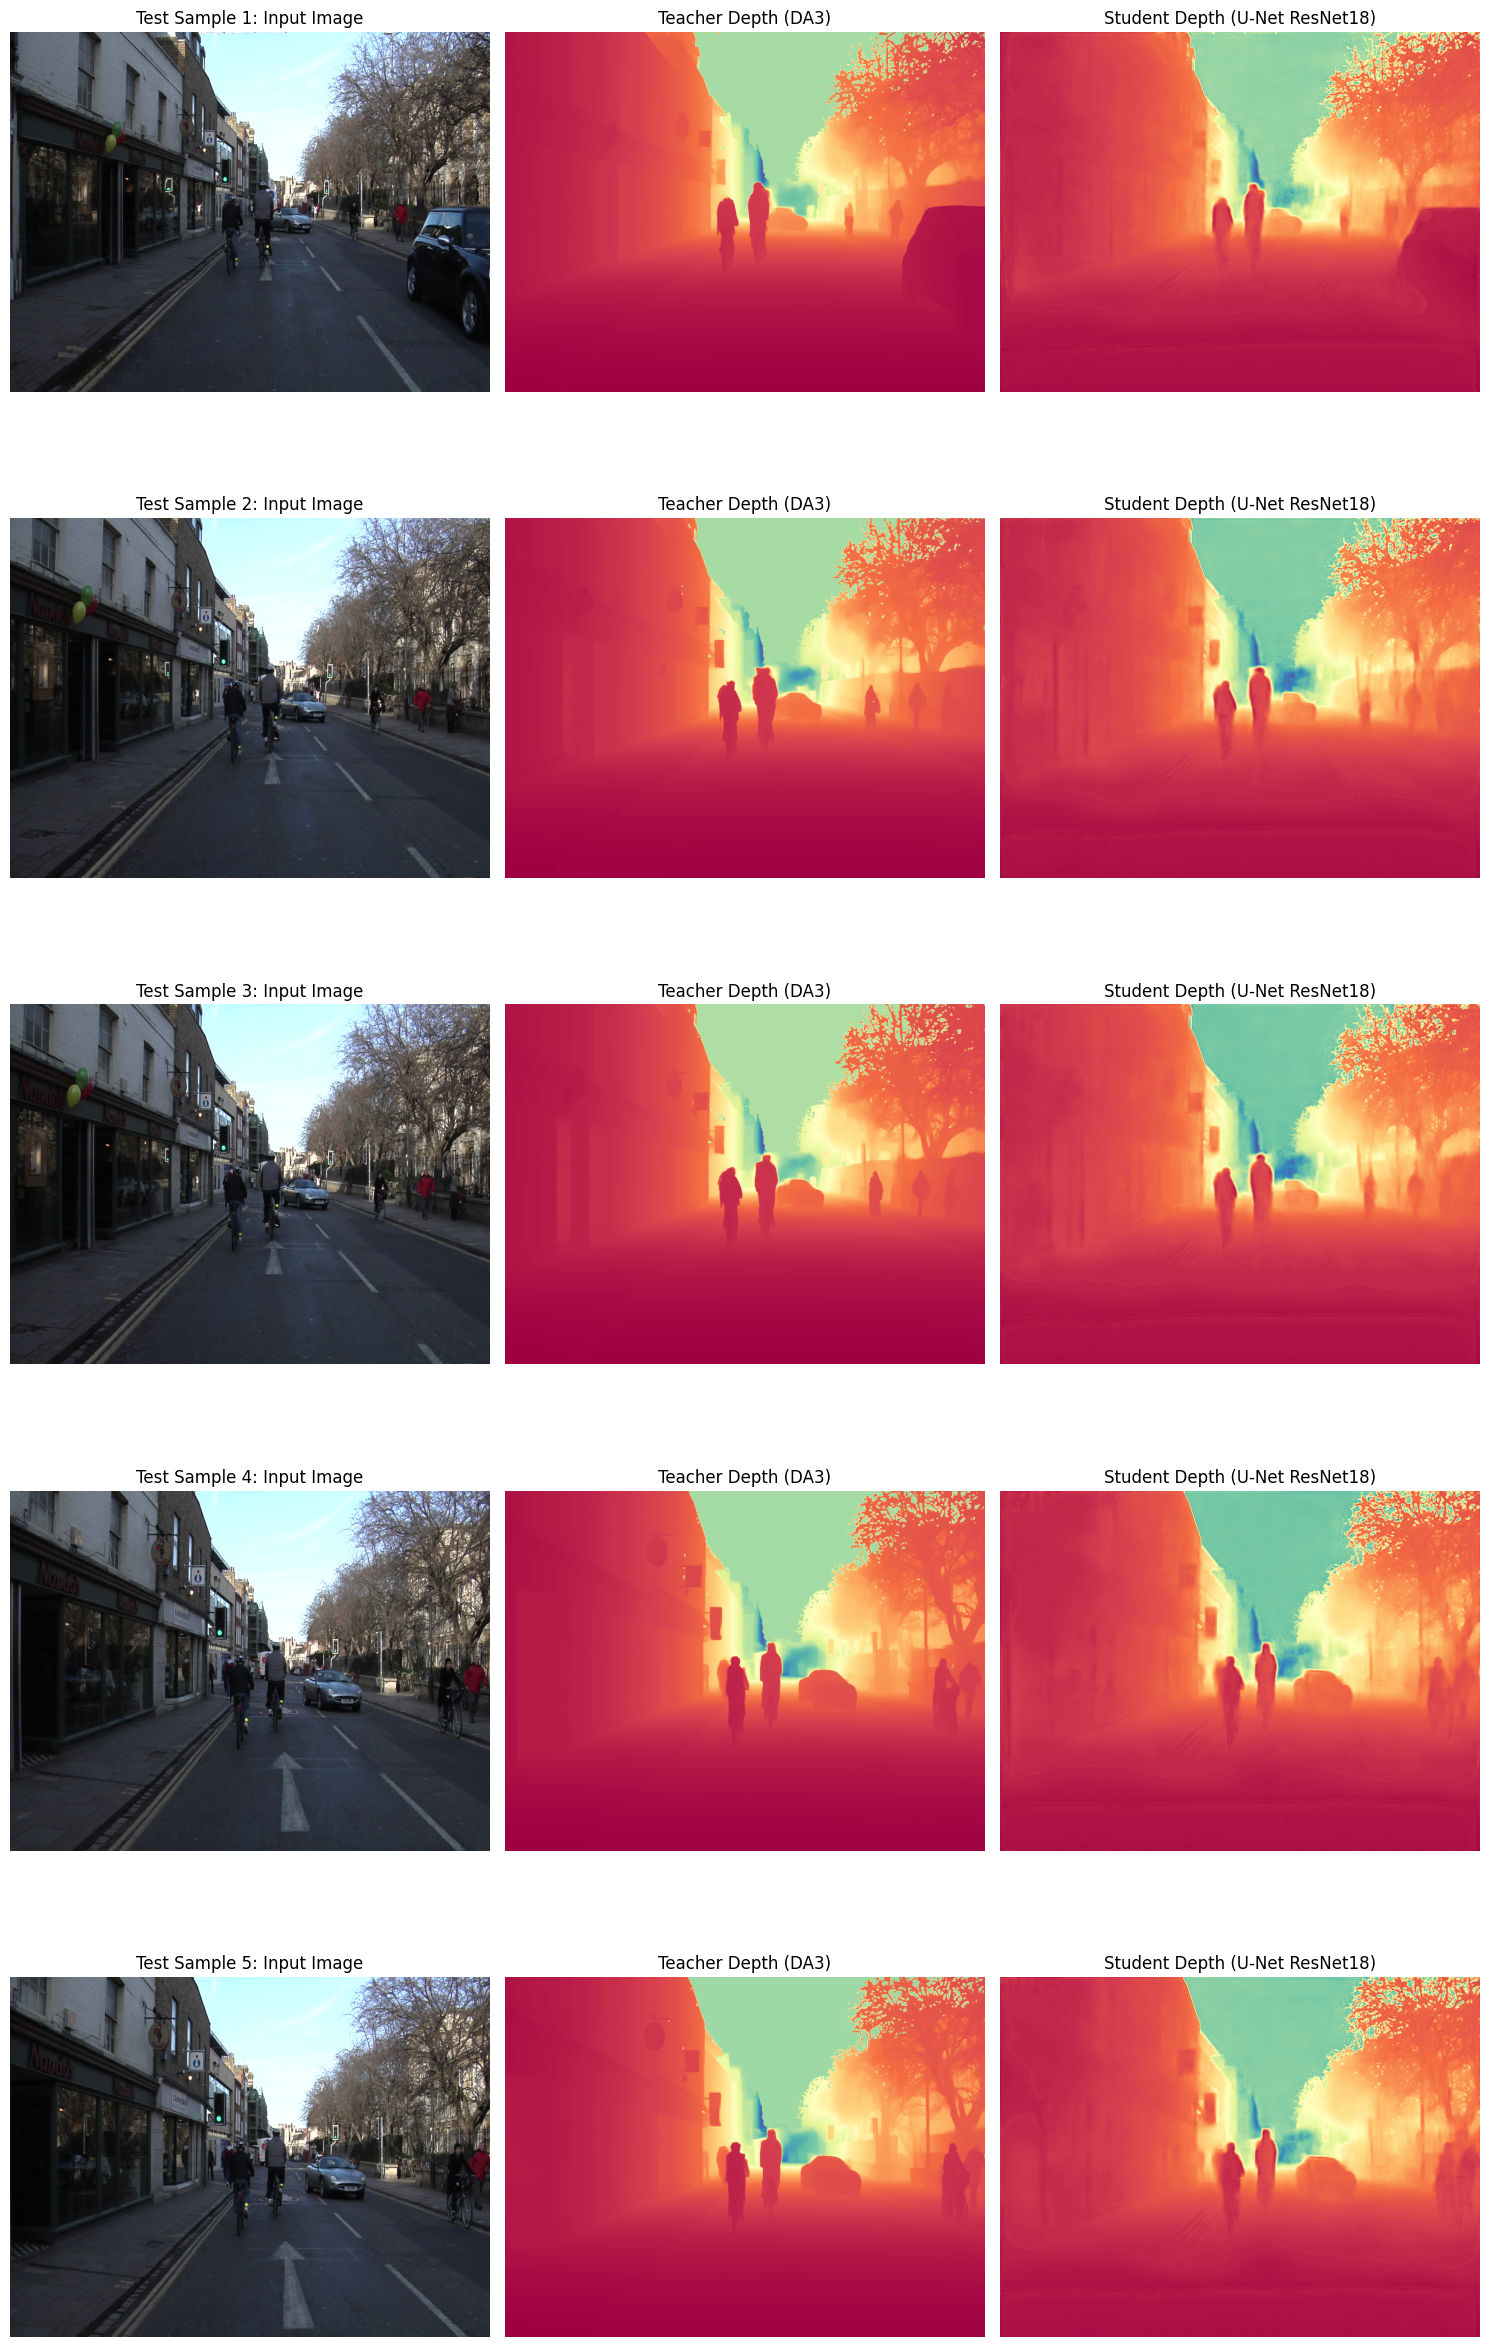

In [10]:
def visualize_predictions(model, dataset, num_samples=5, seed=42, title_prefix="Test"):
    """Visualize student predictions vs teacher depth maps"""
    
    model = model.to(device)
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    random.seed(seed)
    offset = random.randrange(0, len(dataset) - num_samples)
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            image, teacher_depth = dataset[offset + i]
            
            # Get student prediction
            student_pred = model(image.unsqueeze(0).to(device))
            student_pred = student_pred.squeeze().cpu().numpy()
            
            # Denormalize image for visualization
            img_display = image.clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_display = img_display * std + mean
            img_display = torch.clamp(img_display, 0, 1)
            
            # Plot
            axes[i, 0].imshow(img_display.permute(1, 2, 0))
            axes[i, 0].set_title(f'{title_prefix} Sample {i+1}: Input Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(teacher_depth.numpy(), cmap='Spectral')
            axes[i, 1].set_title('Teacher Depth (DA3)')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(student_pred, cmap='Spectral')
            axes[i, 2].set_title('Student Depth (U-Net ResNet18)')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{title_prefix.lower()}_only_hard_loss_depth_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Visualizing predictions on TEST set:")
test_dataset = DepthDistillationDataset(
    img_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
)
visualize_predictions(lightning_module.student, test_dataset, num_samples=5, title_prefix="Test")

## 6.3 Calculate Metrics

In [12]:
def calculate_metrics(model, dataloader, split_name="Test"):
    """Calculate depth estimation metrics"""
    model.to(device)
    model.eval()
    
    total_mse = 0
    total_mae = 0
    total_abs_rel = 0
    num_samples = 0
    
    with torch.no_grad():
        for images, teacher_depth in dataloader:
            images = images.to(device)
            teacher_depth = teacher_depth.to(device)
            
            # Get predictions
            student_pred = model(images).squeeze(1)
            
            # Calculate metrics
            mse = F.mse_loss(student_pred, teacher_depth)
            mae = F.l1_loss(student_pred, teacher_depth)
            
            # Absolute relative error
            abs_rel = torch.mean(torch.abs(student_pred - teacher_depth) / (teacher_depth + 1e-8))
            
            total_mse += mse.item() * images.size(0)
            total_mae += mae.item() * images.size(0)
            total_abs_rel += abs_rel.item() * images.size(0)
            num_samples += images.size(0)
    
    metrics = {
        'MSE': total_mse / num_samples,
        'MAE': total_mae / num_samples,
        'RMSE': np.sqrt(total_mse / num_samples),
        'Abs Rel': total_abs_rel / num_samples
    }
    
    print(f"\n{split_name} Set Metrics:")
    print("=" * 40)
    for metric_name, value in metrics.items():
        print(f"  {metric_name:12s}: {value:.4f}")
    print("=" * 40)
    
    return metrics

# Create data module
test_data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    test_img_dir=TEST_IMG_DIR,
    test_depth_dir=TEST_DEPTH_DIR,
    batch_size=best_params['batch_size'],
    num_workers=2,
    prob=None
)

# Calculate metrics on TEST set
test_loader = data_module.test_dataloader()
test_metrics = calculate_metrics(lightning_module.student, test_loader, split_name="Test")


Test Set Metrics:
  MSE         : 91.8650
  MAE         : 5.4515
  RMSE        : 9.5846
  Abs Rel     : 0.1444


## 6.4 Test Set Detailed Analysis
We will compute the MSE and MAE error of the selected Test samples and visualize the worst performing and best performing samples.


Per-Sample Test Results:
--------------------------------------------------
Sample   0: MSE=262.4543, MAE=9.5971
Sample   1: MSE=227.7441, MAE=9.2058
Sample   2: MSE=166.2514, MAE=8.5096
Sample   3: MSE=168.3578, MAE=8.4029
Sample   4: MSE=294.7101, MAE=10.9285
Sample   5: MSE=225.1926, MAE=9.3795
Sample   6: MSE=227.6173, MAE=9.9222
Sample   7: MSE=215.2927, MAE=10.3508
Sample   8: MSE=224.7870, MAE=11.0767
Sample   9: MSE=176.5527, MAE=9.7708
Sample  10: MSE=188.5386, MAE=10.3129
Sample  11: MSE=113.4889, MAE=7.4081
Sample  12: MSE=144.0110, MAE=8.2001
Sample  13: MSE=106.1066, MAE=6.8295
Sample  14: MSE=126.0492, MAE=7.3882
Sample  15: MSE=122.7063, MAE=7.8003
Sample  16: MSE=118.4730, MAE=7.0687
Sample  17: MSE=164.6525, MAE=9.2784
Sample  18: MSE=198.5336, MAE=9.6471
Sample  19: MSE=181.6513, MAE=9.4968
Sample  20: MSE=157.7182, MAE=7.9876
Sample  21: MSE=189.7798, MAE=8.2504
Sample  22: MSE=151.7405, MAE=7.1684
Sample  23: MSE=308.0521, MAE=11.4422
Sample  24: MSE=177.5175, MAE=

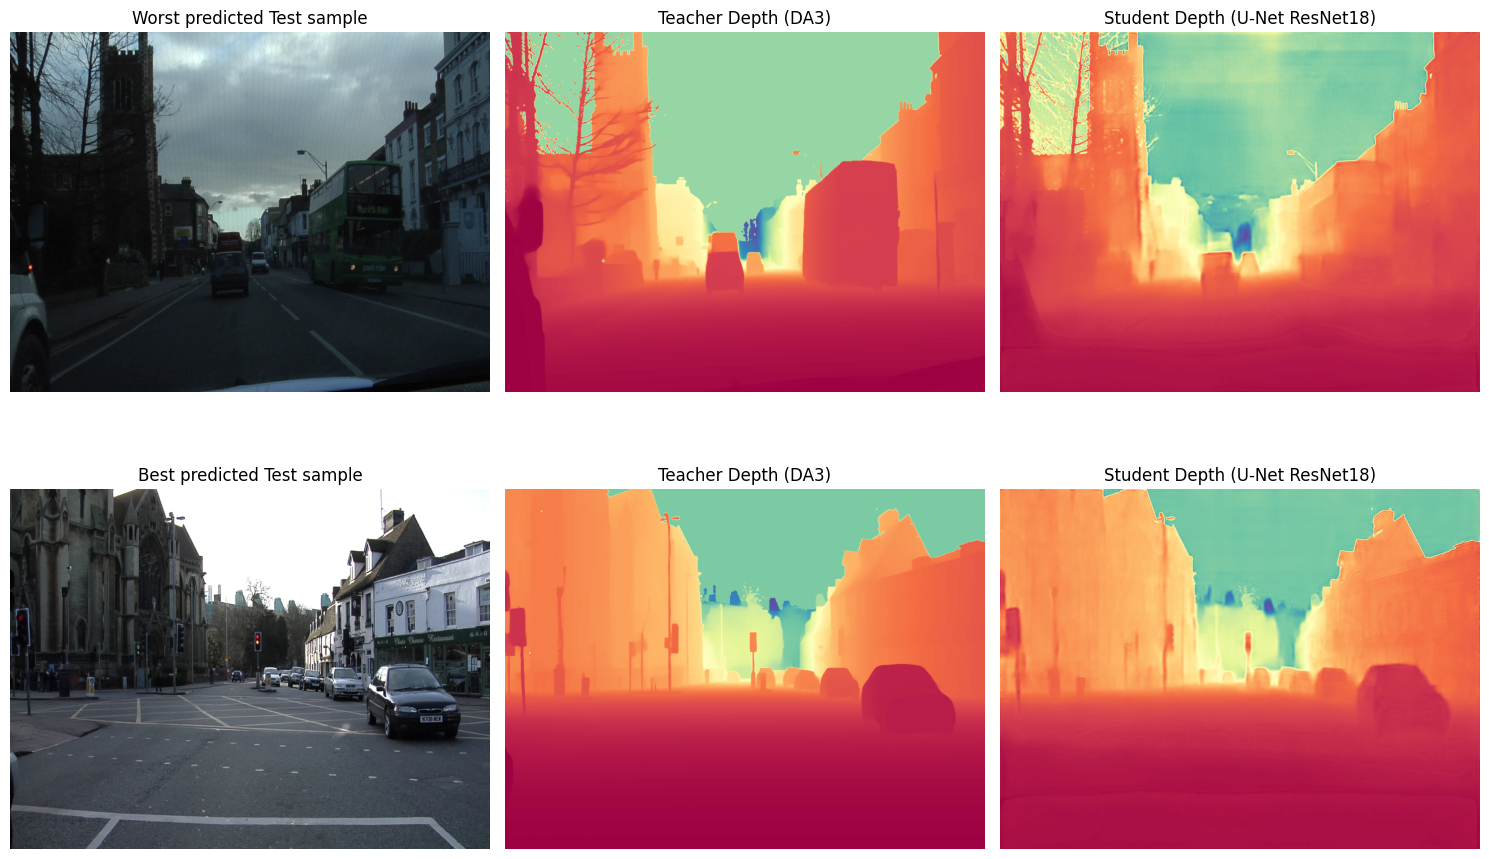

In [13]:
def detailed_test_analysis(model, dataset, num_samples=10):
    """Perform detailed analysis on test samples"""
    model.to(device)
    model.eval()
    
    errors = []

    worst_sample_idx = -1
    best_sample_idx = -1
    best_mse = np.inf
    worst_mse = 0
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            image, teacher_depth = dataset[i]
            
            # Get prediction
            student_pred = model(image.unsqueeze(0).to(device))
            student_pred = student_pred.squeeze().cpu()
            
            # Calculate per-sample error
            mse = F.mse_loss(student_pred, teacher_depth).item()
            mae = F.l1_loss(student_pred, teacher_depth).item()
            
            errors.append({
                'sample_idx': i,
                'MSE': mse,
                'MAE': mae
            })

            # Track worst and best samples taking into account MSE value
            if mse > worst_mse:
                worst_mse = mse
                worst_sample_idx = i
                
            if mse < best_mse:
                best_mse = mse
                best_sample_idx = i
    
    # Print per-sample results
    print("\nPer-Sample Test Results:")
    print("-" * 50)
    for error in errors:
        print(f"Sample {error['sample_idx']:3d}: MSE={error['MSE']:.4f}, MAE={error['MAE']:.4f}")
    
    # Statistical summary
    mse_values = [e['MSE'] for e in errors]
    mae_values = [e['MAE'] for e in errors]
    
    print("\nStatistical Summary:")
    print("-" * 50)
    print(f"MSE - Mean: {np.mean(mse_values):.4f}, Std: {np.std(mse_values):.4f}")
    print(f"MAE - Mean: {np.mean(mae_values):.4f}, Std: {np.std(mae_values):.4f}")

    return worst_sample_idx, best_sample_idx

def visualize_edge_predictions(model, dataset, worst_sample_idx, best_sample_idx):
    """Visualize student predictions vs teacher depth maps"""
    
    model = model.to(device)
    model.eval()
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    with torch.no_grad():

        # Worst predicted sample
        image, teacher_depth = dataset[worst_sample_idx]
            
        # Get student prediction
        student_pred = model(image.unsqueeze(0).to(device))
        student_pred = student_pred.squeeze().cpu().numpy()
        
        # Denormalize image for visualization
        img_display = image.clone()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_display = img_display * std + mean
        img_display = torch.clamp(img_display, 0, 1)
        
        # Plot
        axes[0, 0].imshow(img_display.permute(1, 2, 0))
        axes[0, 0].set_title(f'Worst predicted Test sample')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(teacher_depth.numpy(), cmap='Spectral')
        axes[0, 1].set_title('Teacher Depth (DA3)')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(student_pred, cmap='Spectral')
        axes[0, 2].set_title('Student Depth (U-Net ResNet18)')
        axes[0, 2].axis('off')

        # Best predicted sample
        image, teacher_depth = dataset[best_sample_idx]
            
        # Get student prediction
        student_pred = model(image.unsqueeze(0).to(device))
        student_pred = student_pred.squeeze().cpu().numpy()
        
        # Denormalize image for visualization
        img_display = image.clone()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_display = img_display * std + mean
        img_display = torch.clamp(img_display, 0, 1)
        
        # Plot
        axes[1, 0].imshow(img_display.permute(1, 2, 0))
        axes[1, 0].set_title(f'Best predicted Test sample')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(teacher_depth.numpy(), cmap='Spectral')
        axes[1, 1].set_title('Teacher Depth (DA3)')
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(student_pred, cmap='Spectral')
        axes[1, 2].set_title('Student Depth (U-Net ResNet18)')
        axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'worst_best_test_only_hard_loss_depth_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

# Run detailed analysis
test_dataset = DepthDistillationDataset(
    img_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
)

worst_sample_idx, best_sample_idx = detailed_test_analysis(lightning_module.student, test_dataset, num_samples=len(test_dataset))
print(f"Worst predicted sample found at image #{worst_sample_idx}")
print(f"Best predicted sample found at image #{best_sample_idx}")
print()

visualize_edge_predictions(lightning_module.student, test_dataset, worst_sample_idx, best_sample_idx)